## Importing librairies

In [1]:
# Importing librairies
import os 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## importing dataset

In [4]:
# ====== IMPORTING DATASET ======
datasets = os.getenv("TRAIN_DATASET")
customer = pd.read_excel(datasets)
print("Dataset Impoted ✅✅")

Dataset Impoted ✅✅


In [26]:
# customer.columns
# customer["Satisfaction_Score"].min()
# customer["Satisfaction_Score"].max()
customer["Preferred_Category"].unique()

array(['Fashion', 'Health', 'Home', 'Electronics', nan, 'Leisure'],
      dtype=object)

## Data Preprocessing

In [85]:
# ====== SEPARATION OF DATA TYPES ======
num_col = customer.select_dtypes(include=['int64','float64']).columns.tolist()
cat_col = customer.select_dtypes(include=['object']).columns.tolist()

# ====== PIPELINE ======
# Categoricals columns
cat_transformers = Pipeline([
    ("imputer",SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(sparse_output=True, handle_unknown='ignore'))
])

# Numericals columns
num_transformers = Pipeline([
    ("impute", KNNImputer(n_neighbors=3)),
    ("scaler", StandardScaler())
])

# Preprocessing
preprocessors = ColumnTransformer(
    transformers=[
        ("cat", cat_transformers, cat_col),
        ('num', num_transformers,num_col)
    ]
)

# ====== PRINCIPAL COMPONENTS ANALYSIS ======
pipeline = Pipeline([
    ("preprocess", preprocessors),
    ("pca", PCA(n_components=10))
])

# ====== DATA TRANSFORMING ======
data_transformed = pipeline.fit_transform(customer)
print("PCA Passed ✅✅")

PCA Passed ✅✅


## Elbow Method

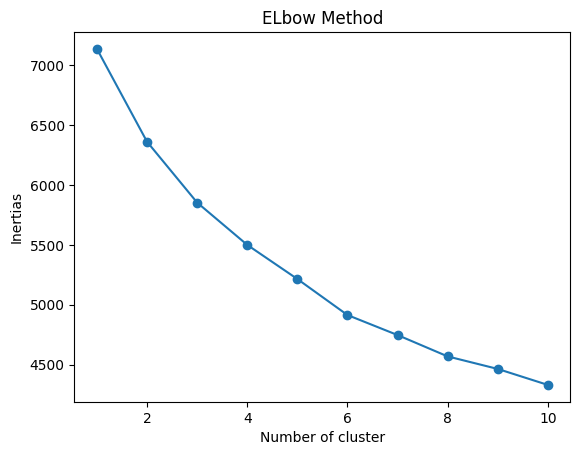

In [85]:
# ====== ELBOW METHOD ======
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_transformed)
    inertias.append(kmeans.inertia_)

# Visualization
plt.plot(range(1,11), inertias, marker='o')
plt.title("ELbow Method")
plt.xlabel('Number of cluster')
plt.ylabel("Inertias")
plt.show()

## Silhouette Coefficient Method

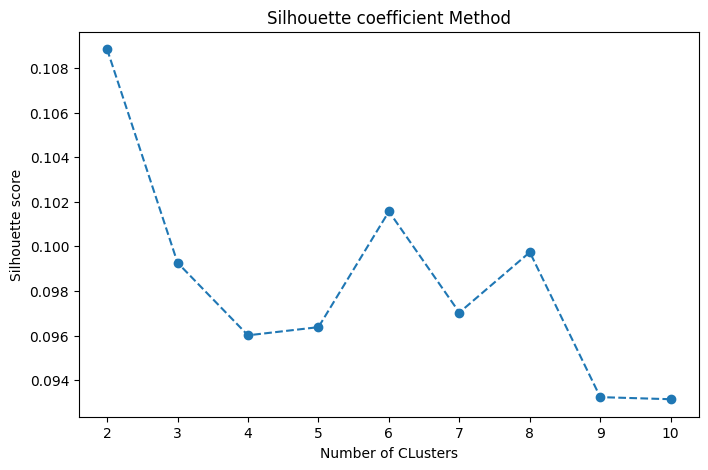

In [86]:
# ====== SILHOUETTE COEFFICIENT METHOD ======
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_transformed)
    score = silhouette_score(data_transformed, clusters)
    silhouette_scores.append(score)

# Visualization
plt.figure(figsize=(8, 5))
plt.plot(range(2,11), silhouette_scores, marker="o", linestyle="--")
plt.xlabel("Number of CLusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette coefficient Method")
plt.show()

## Applying Kmeans

In [86]:
# ====== APPLYING KMEANS ======
optimal_k = 3
kmean = KMeans(n_clusters=3, random_state=42)
clusters = kmean.fit_predict(data_transformed)
customer["Clusters"] = clusters
print("KMeans Applied ✅✅")

KMeans Applied ✅✅


## Visualizing Centroids

In [88]:
# Centroids
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_transformed)
centroids =pca.transform(kmean.cluster_centers_)
print("PCA Applied for visualizing Centroids ✅✅")

PCA Applied for visualizing Centroids ✅✅


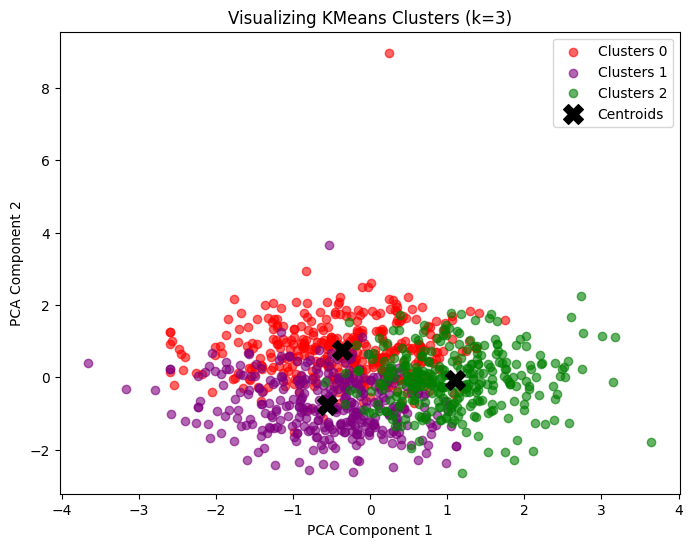

In [89]:
# Visualization
plt.figure(figsize=(8,6))
colors = ["red","purple","green"]

for i in range(optimal_k):
    plt.scatter(data_pca[clusters == i, 0], data_pca[clusters == i, 1],label = f"Clusters {i}", alpha=0.6, color =colors[i])

plt.scatter(centroids[:, 0], centroids[:,1], marker="X", s=200, c="black", label ="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Visualizing KMeans Clusters (k={optimal_k})")
plt.legend()
plt.show()

## Average analysis

In [ ]:
# ====== AVERAGE ANALYSIS ======
cluster_summary = customer.groupby("Clusters")[num_col].mean()

cluster_summary


Age  Annual_Income  Spending_Score  Visit_Frequency  \
Clusters                                                              
0         42.273775   55611.113314       51.008403         4.501416   
1         39.413174   46258.376506       52.697885         4.217523   
2         50.923611   52398.303887       45.510638         6.297203   

          Average_Basket  Satisfaction_Score  
Clusters                                      
0             141.687949            4.412088  
1             118.318762            1.839009  
2             192.400868            2.362989

## Most frequent category by cluster

In [94]:
cluster_proportions = customer.groupby("Clusters")["Used_Discount"].value_counts(normalize=True)
cluster_proportions

Clusters  Used_Discount
0         Non              0.710145
          Oui              0.289855
1         Non              0.638554
          Oui              0.361446
2         Non              0.711340
          Oui              0.288660
Name: proportion, dtype: float64

## Cluster Proportion by categories

In [95]:
cluster_proportions = customer.groupby("Clusters")["Preferred_Category"].value_counts(normalize=True)
cluster_proportions

Clusters  Preferred_Category
0         Electronics           0.224138
          Health                0.218391
          Leisure               0.206897
          Fashion               0.183908
          Home                  0.166667
1         Electronics           0.232836
          Health                0.220896
          Fashion               0.188060
          Home                  0.182090
          Leisure               0.176119
2         Home                  0.227273
          Leisure               0.223776
          Fashion               0.192308
          Electronics           0.188811
          Health                0.167832
Name: proportion, dtype: float64

In [93]:
# Catégorie la plus fréquente par cluster
for col in cat_col:
    mode_per_cluster = customer.groupby("Clusters")[col].agg(lambda x: x.mode()[0])
    print(f"\nCatégorie dominante de {col} par Cluster :\n{mode_per_cluster}")


Catégorie dominante de Used_Discount par Cluster :
Clusters
0    Non
1    Non
2    Non
Name: Used_Discount, dtype: object

Catégorie dominante de Preferred_Category par Cluster :
Clusters
0    Electronics
1    Electronics
2           Home
Name: Preferred_Category, dtype: object


## Label Engineering

In [87]:
# Création de la variable "Churn" à partir 
customer['Churn'] = (customer['Satisfaction_Score'] <= 3) & (customer['Visit_Frequency'] <= 4 )
customer['Churn'] = customer['Churn'].astype(int)
customer["Clusters"] = customer["Clusters"].replace({0: "Cluster_0", 1: "Cluster_1", 2: "Cluster_2"})
# Suppression de la colonnes "Age"
customer =customer.drop(columns="Age")

# Exportation du nouveau jeu de données 
customer.to_excel("../data/data_kmeans.xlsx", index=False)

In [88]:
customer.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Annual_Income       968 non-null    float64
 1   Spending_Score      970 non-null    float64
 2   Visit_Frequency     970 non-null    float64
 3   Average_Basket      967 non-null    float64
 4   Used_Discount       968 non-null    object 
 5   Preferred_Category  969 non-null    object 
 6   Satisfaction_Score  968 non-null    float64
 7   Clusters            1020 non-null   object 
 8   Churn               1020 non-null   int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 71.8+ KB
